# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

# Our functions

In [3]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores
from PPO import ppo_update, RolloutBuffer, evaluate_policy

# Training loop for OPPO
from OPPO import baseline_CartPole_V0, baseline_MountainCar, OPPO_update
from OPPO import baseline_1, baseline_CartPole_v0_Fla


## Parameters

In [ ]:
# Choose environment:

# env 1: CartPole-v0
env_name='CartPole-v0'
baseline = baseline_CartPole_v0_Fla
target_score = 190 # for CartPole-v0

# env 2: Continuous-MountainCar-v0
# env_name='MountainCar-v0'
# baseline = baseline_MountainCar
# target_score = -110 # for Continuous-MountainCar-v0

lr_oppo = 0.01

load_policies = False

# ── Hyperparams for OPPO ──
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 200  # cap on steps per episode
print_every             = 20   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99

seed_training_policies  = 42


In [4]:
# ── Instantiate the two policies & optimizers for OPPO ──
env_oppo   = gym.make(env_name)

pi1_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))
  pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


# ── Run the OPPO training ──
if not load_policies:
  # Training the policy:
  scores_oppo = OPPO_update(
      policy       = pi1_oppo,
      optimizer    = opt1_oppo,
      env          = env_oppo,
      baseline     = baseline,
      n_episodes   = n_episodes,
      max_t        = max_t,
      gamma        = gamma,      # you can reuse your PPO γ
      print_every  = print_every,
      early_stop   = False,
      seed = seed_training_policies,
      target_score = target_score,
      env_name= env_name
  )





c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/1200 [00:00<?, ?it/s]

Episode 20 	 Average Score over the last 20 episodes: 18.7
Episode 40 	 Average Score over the last 20 episodes: 31.1
Episode 60 	 Average Score over the last 20 episodes: 47.5
Episode 80 	 Average Score over the last 20 episodes: 66.3
Environment reached the half target score in 94 episodes! Average Score: 96.85
Saving the policy in pi2_oppo_CartPole-v0.pth...
Episode 100 	 Average Score over the last 20 episodes: 95.0
Episode 120 	 Average Score over the last 20 episodes: 143.4
Episode 140 	 Average Score over the last 20 episodes: 157.7
Episode 160 	 Average Score over the last 20 episodes: 126.5
Episode 180 	 Average Score over the last 20 episodes: 187.7
Environment reached the target score (cumulative rewards) in 181 episodes! Average Score: 192.80
Saving the policy in pi1_oppo_CartPole-v0.pth...


In [ ]:
# Choose environment:

# env 1: CartPole-v0
# env_name='CartPole-v0'
# baseline = baseline_CartPole_v0_Fla
# target_score = 190 # for CartPole-v0

# env 2: Continuous-MountainCar-v0
env_name='MountainCar-v0'
baseline = baseline_MountainCar
target_score = -110 # for Continuous-MountainCar-v0

lr_oppo = 0.01

load_policies = False

# ── Hyperparams for OPPO ──
n_episodes              = 2400 # keep same “number of iterations” for fair comparison
max_t                   = 200  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99 # parameter for OPPO

seed_training_policies  = 42


In [6]:
# ── Instantiate the two policies & optimizers for OPPO ──
env_oppo   = gym.make(env_name)

pi1_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))
  pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


# ── Run the OPPO training ──
if not load_policies:
  # Training the policy:
  scores_oppo = OPPO_update(
      policy       = pi1_oppo,
      optimizer    = opt1_oppo,
      env          = env_oppo,
      baseline     = baseline,
      n_episodes   = n_episodes,
      max_t        = max_t,
      gamma        = gamma,      # you can reuse your PPO γ
      print_every  = print_every,
      early_stop   = False,
      seed = seed_training_policies,
      target_score = target_score,
      env_name= env_name
  )





c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/1200 [00:00<?, ?it/s]

Episode 50 	 Average Score over the last 50 episodes: -200.0
Episode 100 	 Average Score over the last 50 episodes: -200.0
Episode 150 	 Average Score over the last 50 episodes: -200.0
Episode 200 	 Average Score over the last 50 episodes: -200.0
Episode 250 	 Average Score over the last 50 episodes: -200.0
Episode 300 	 Average Score over the last 50 episodes: -200.0
Episode 350 	 Average Score over the last 50 episodes: -200.0
Episode 400 	 Average Score over the last 50 episodes: -200.0
Episode 450 	 Average Score over the last 50 episodes: -200.0
Episode 500 	 Average Score over the last 50 episodes: -200.0
Episode 550 	 Average Score over the last 50 episodes: -200.0
Episode 600 	 Average Score over the last 50 episodes: -200.0
Episode 650 	 Average Score over the last 50 episodes: -200.0
Episode 700 	 Average Score over the last 50 episodes: -200.0
Episode 750 	 Average Score over the last 50 episodes: -200.0
Episode 800 	 Average Score over the last 50 episodes: -200.0
Episode 8

## Demonstration of our Policies for CartPole_v0 environment:

c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Evaluations over 100 episodes done for both policies


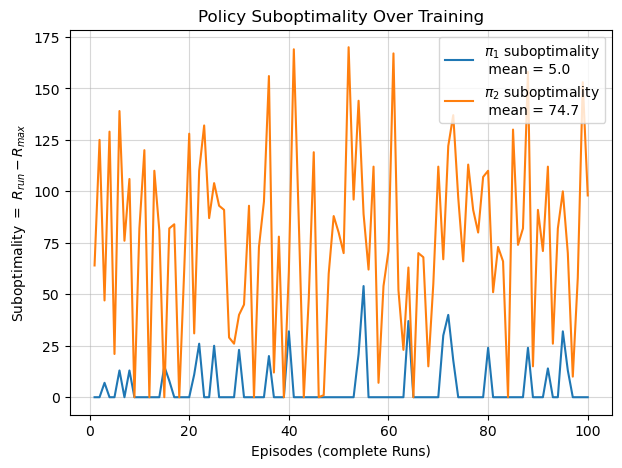

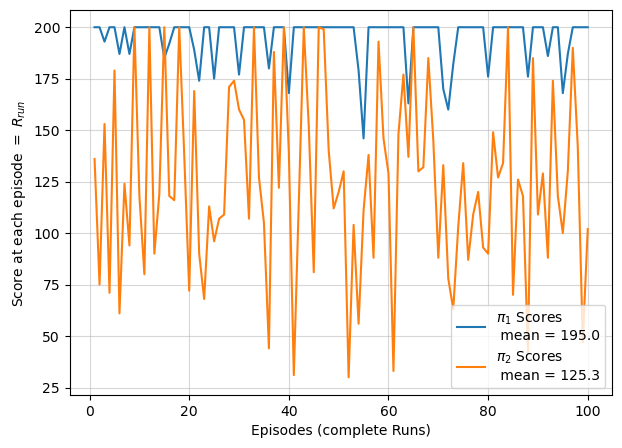

In [5]:
env_name='CartPole-v0'
baseline = baseline_CartPole_v0_Fla
target_score = 190 # for CartPole-v0

lr_oppo = 0.01

load_policies = True


# ── Instantiate the two policies & optimizers for OPPO ──
env_oppo   = gym.make(env_name)

pi1_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))
  pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


seed_evaluation = 26
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(pi1_oppo, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(pi2_oppo, env_oppo, n_episodes=num_episodes)
print("Evaluations over", num_episodes, "episodes done for both policies")

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    max_reward=200, # for CartPole-v0
)

plot_Scores(
    pi1_reward,
    pi2_reward,
)
